In [215]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prometheus_pandas import query
from IPython.display import Markdown, display

pd.__version__

'2.0.0'

In [216]:
p = query.Prometheus('http://192.168.178.64:9090')
step = "1s"

In [217]:
# We're scraping much more data than we actually need.
# This is especially true for devices.
# In this section we define which devices we actually want to analyze.

NET_DEVICES=["docker0","enp7s0","lo"]
DISK_DEVICES=["sda"]

# Utils

In [218]:
def printmd(string):
    display(Markdown(string))
    
def remove_meta_columns(df):
    cols = [col for col in df.columns if col not in ['measurement','seconds']]
    return df[cols]

    
def describe_measurement_dataframe(df):
    printmd("### Total ")
    display(remove_meta_columns(df).describe())
    
    printmd("### Per Measurement")
    display(df[df.columns.difference(['seconds'])].groupby('measurement').describe().unstack(1))

def prepare_query_range_as_dataframe(measurement_no, query, start, end, step=step):
    print(f"[Measurement {measurement_no}] Querying '{query}' from {start} to {end} with step {step} ...")
    metrics = p.query_range(query, start, end, step)
    metrics = metrics.assign(seconds=range(len(metrics)))
    metrics = metrics.assign(measurement=measurement_no)
    
    summarize_outliers(metrics.reset_index())
    
    return metrics


def prepare_query_metrics_as_dataframe(measurement_no, query, end):
    print(f"[Measurement {measurement_no}] Querying '{query}' at {end} ...")
    metrics = p.query(query, end).to_frame()
    metrics.columns = ['value']
    metrics = metrics.assign(measurement=measurement_no)

    summarize_outliers(metrics.reset_index())
    
    return metrics


def prepare_dataframe(query_fn, df):
    result = [prepare_query_range_as_dataframe(idx, query_fn(start, duration, end), start, end) for idx, (start, duration, end) in enumerate(zip(df['Start'], df['Duration'], df['End']), 1)]
    result = pd.concat(result)
    return result


def prepare_series(query_fn, df):
    result = [prepare_query_metrics_as_dataframe(idx, query_fn(start, duration, end), end) for idx, (start, duration, end) in enumerate(zip(df['Start'], df['Duration'], df['End']), 1)]
    result = pd.concat(result)
    return result


def mark_outliers(df, fence=2.22):
    # Select only numeric columns
    cols = df.select_dtypes('number').columns
    df_sub = df.loc[:, cols]
    
    # Calculate IQR
    iqr = df_sub.quantile(0.75, numeric_only=False) - df_sub.quantile(0.25, numeric_only=False)
    lim = np.abs((df_sub - df_sub.median()) / iqr) < fence
    
    # Replace Outliers with NaN
    df.loc[:, cols] = df_sub.where(lim, np.nan)
    
    # Replace all NaN values
    return df


def summarize_outliers(df, fence=2.22):
    marked_outliers = mark_outliers(df, fence)
    diff = df.compare(marked_outliers)
    
    # No Outliers, no problem
    if diff.size == 0:
        return
    
    diff.name = 'Outliers'
    print('Outliers detected, please check manually')
    print(diff)
    

def drop_outliers(df, fence=2.22):
    cols = df.select_dtypes('number').columns
    return mark_outliners(df, fence).dropna(how='any', subset=cols)

# Data Preparation

In [219]:
DEFAULT_RANGE="10s"
# This is going to be the label filter we're going to use
net_filter_label = f"{{device=~\"{'|'.join(NET_DEVICES)}\"}}"
# This is going to be the label filter we're going to use
disk_filter_label = f"{{device=~\"{'|'.join(DISK_DEVICES)}\"}}"
interrupts_filter = f"{{devices=\"\"}}"

def prepare_power_metrics(measurement_dataframe):
    power_metrics = prepare_dataframe(lambda start,duration,end: '{__name__=~"epc1202PowerActive|epc1202Current|epc1202Voltage"}', measurement_dataframe)
    power_metrics.columns = ['Current', 'Watts', 'Voltage', 'seconds', 'measurement']
    return power_metrics

def prepare_cpu_seconds_in_mode(measurement_dataframe):
    return prepare_series(lambda start,duration,end: f"avg by (mode) (increase(node_cpu_seconds_total[{duration}]))", measurement_dataframe)

def prepare_cpu_utilization(measurement_dataframe):
    rng = DEFAULT_RANGE
    return prepare_dataframe(lambda start, duration, end: f"avg by (mode) (rate(node_cpu_seconds_total[{DEFAULT_RANGE}]) * 100)", measurement_dataframe)

def prepare_memory_utilization(measurement_dataframe):
    rng = DEFAULT_RANGE
    query = f"""
      100 * (1 - ((avg_over_time(node_memory_MemFree_bytes[{rng}]) + avg_over_time(node_memory_Cached_bytes[{rng}]) + avg_over_time(node_memory_Buffers_bytes[{rng}])) / avg_over_time(node_memory_MemTotal_bytes[{rng}])))
    """
    return prepare_dataframe(lambda start, duration, end: query, measurement_dataframe)

def prepare_network_received_bytes(measurement_dataframe):
    return prepare_series(lambda start, duration, end: f"sum by(device) (increase(node_network_receive_bytes_total{net_filter_label}[{duration}])) / 1000", measurement_dataframe)

def prepare_network_transmitted_bytes(measurement_dataframe):
    return prepare_series(lambda start, duration, end: f"sum by(device) (increase(node_network_transmit_bytes_total{net_filter_label}[{duration}])) / 1000", measurement_dataframe)

def prepare_network_average_receive_rate(measurement_dataframe):
    return prepare_dataframe(lambda start, duration, end: f"avg by (device) (rate(node_network_receive_bytes_total{net_filter_label}[{DEFAULT_RANGE}]))", measurement_dataframe)

def prepare_network_average_transmit_rate(measurement_dataframe):
    return prepare_dataframe(lambda start, duration, end: f"avg by (device) (rate(node_network_transmit_bytes_total{net_filter_label}[{DEFAULT_RANGE}]))", measurement_dataframe)

def prepare_total_disk_io_seconds(measurement_dataframe):
    return prepare_series(lambda start, duration, end: f"increase(node_disk_io_time_seconds_total{disk_filter_label}[{DEFAULT_RANGE}])", measurement_dataframe)

def prepare_disk_io_rate(measurement_dataframe):
    return prepare_dataframe(lambda start, duration, end: f"avg by (device) (rate(node_disk_io_time_seconds_total{disk_filter_label}[{DEFAULT_RANGE}]))", measurement_dataframe)

def prepare_interrupts(measurement_dataframe):
    return prepare_series(lambda start, duration, end: f"sum by (devices, type) (idelta(node_interrupts_total{interrupts_filter}[{duration}]) > 0)", measurement_dataframe)

# Baseline Analysis

Here we take a look at the Baseline of our DUT


In [264]:
bm = pd.read_csv('baseline.csv')
bm

,Start,End,Duration,Energy
0,1681634834,1681635134,5m,4


## Power Stats

[Measurement 1] Querying '{__name__=~"epc1202PowerActive|epc1202Current|epc1202Voltage"}' from 1681634834 to 1681635134 with step 1s ...


### Total 

,Current,Watts,Voltage
count,301.000000,301.000000,301.000000
mean,262.259136,47.438538,237.239203
std,0.786951,0.497034,0.427307
min,261.000000,47.000000,237.000000
25%,262.000000,47.000000,237.000000
50%,262.000000,47.000000,237.000000
75%,263.000000,48.000000,237.000000
max,265.000000,48.000000,238.000000


### Per Measurement

                measurement
Current  count  1              301.000000
         mean   1              262.259136
         std    1                0.786951
         min    1              261.000000
         25%    1              262.000000
         50%    1              262.000000
         75%    1              263.000000
         max    1              265.000000
Voltage  count  1              301.000000
         mean   1              237.239203
         std    1                0.427307
         min    1              237.000000
         25%    1              237.000000
         50%    1              237.000000
         75%    1              237.000000
         max    1              238.000000
Watts    count  1              301.000000
         mean   1               47.438538
         std    1                0.497034
         min    1               47.000000
         25%    1               47.000000
         50%    1               47.000000
         75%    1               48.000000
      

### Current Measurment Plots

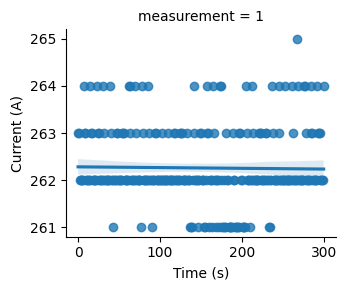

### Voltage Measurment Plots

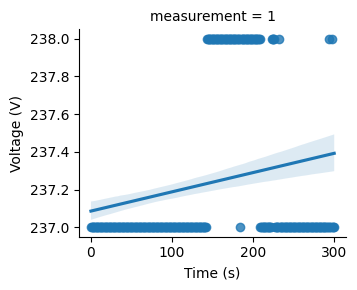

### Watts Measurment Plots

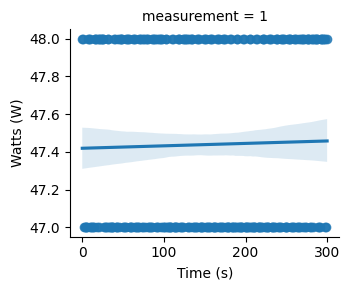

### Mean Watts

,Current,Watts,Voltage,measurement
count,301.000000,301.000000,301.000000,301.0
mean,262.259136,47.438538,237.239203,1.0
std,0.786951,0.497034,0.427307,0.0
min,261.000000,47.000000,237.000000,1.0
25%,262.000000,47.000000,237.000000,1.0
50%,262.000000,47.000000,237.000000,1.0
75%,263.000000,48.000000,237.000000,1.0
max,265.000000,48.000000,238.000000,1.0


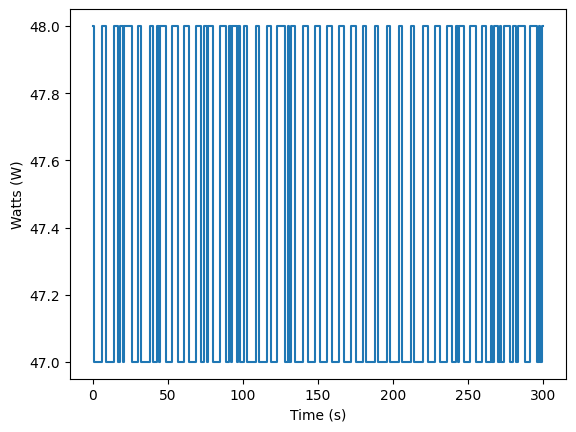

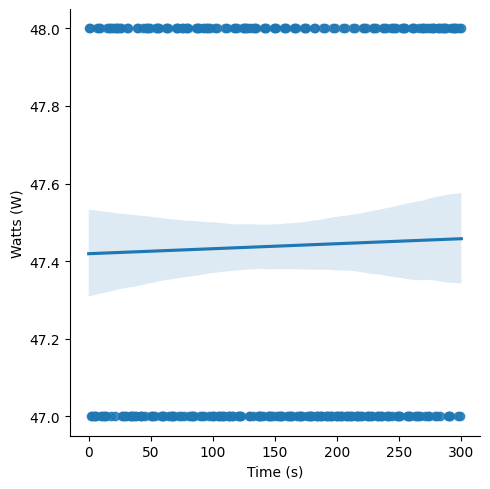

In [277]:
power_metrics = prepare_power_metrics(bm)
describe_measurement_dataframe(power_metrics)

printmd("### Current Measurment Plots")
fg = sns.lmplot(
      data=power_metrics, x="seconds", y="Current", col="measurement", col_wrap=5, height=3, scatter=True
)
fg.set_xlabels("Time (s)")
fg.set_ylabels("Current (A)")
plt.show(fg)

printmd("### Voltage Measurment Plots")
fg = sns.lmplot(
    data=power_metrics, x="seconds", y="Voltage", col="measurement", col_wrap=5, height=3, scatter=True
)
fg.set_xlabels("Time (s)")
fg.set_ylabels("Voltage (V)")
plt.show(fg)

printmd("### Watts Measurment Plots")
fg = sns.lmplot(
      data=power_metrics, x="seconds", y="Watts", col="measurement", col_wrap=5, height=3, scatter=True
)
fg.set_xlabels("Time (s)")
fg.set_ylabels("Watts (W)")
plt.show(fg)        

printmd("### Mean Watts")

mean_per_second = power_metrics.groupby(by=['seconds']).mean()
display(mean_per_second.describe())

fig = mean_per_second['Watts'].plot(drawstyle='steps')
fig.set_xlabel("Time (s)")
fig.set_ylabel("Watts (W)")
plt.show(fig)

fg = sns.lmplot(
      data=mean_per_second.reset_index(), x="seconds", y="Watts", scatter=True
)
fg.set_xlabels("Time (s)")
fg.set_ylabels("Watts (W)")
plt.show(fg)    

## CPU

### CPU Time

[Measurement 1] Querying 'avg by (mode) (increase(node_cpu_seconds_total[5m]))' at 1681635134 ...


### Total 

,value
count,8.000000
mean,37.464413
std,105.365199
min,0.000000
25%,0.000000
50%,0.020067
75%,0.464047
max,298.227843


### Per Measurement

              measurement
value  count  1                8.000000
       mean   1               37.464413
       std    1              105.365199
       min    1                0.000000
       25%    1                0.000000
       50%    1                0.020067
       75%    1                0.464047
       max    1              298.227843
dtype: float64

,value
"{mode=""idle""}",298.227843
"{mode=""iowait""}",0.003135
"{mode=""irq""}",0.000000
"{mode=""nice""}",0.000000
"{mode=""softirq""}",0.036998
"{mode=""steal""}",0.000000
"{mode=""system""}",0.204431
"{mode=""user""}",1.242893


<Axes: ylabel='CPU seconds'>

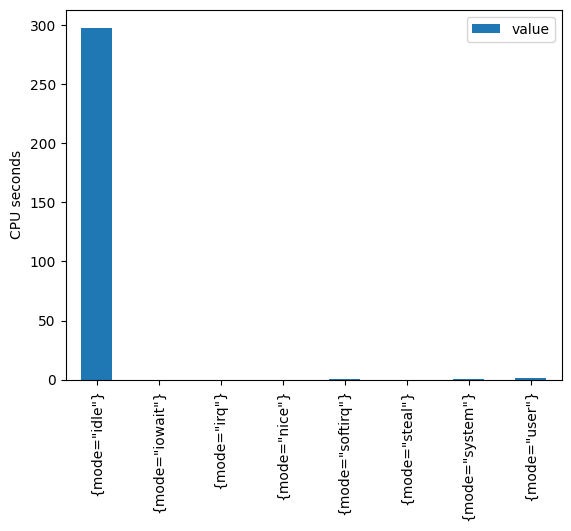

In [227]:
cpu_metrics = prepare_cpu_seconds_in_mode(bm)
describe_measurement_dataframe(cpu_metrics)

total_mean_result = remove_meta_columns(cpu_metrics).groupby(level=0).mean()

display(total_mean_result)
total_mean_result.plot.bar(ylabel='CPU seconds')

### CPU Utilization

[Measurement 1] Querying 'avg by (mode) (rate(node_cpu_seconds_total[10s]) * 100)' from 1681634834 to 1681635134 with step 1s ...


### Total 

,"{mode=""idle""}","{mode=""iowait""}","{mode=""irq""}","{mode=""nice""}","{mode=""softirq""}","{mode=""steal""}","{mode=""system""}","{mode=""user""}"
count,301.000000,301.000000,301.0,301.0,301.000000,301.0,301.000000,301.000000
mean,99.407577,0.001038,0.0,0.0,0.012159,0.0,0.068568,0.416182
std,0.082584,0.002668,0.0,0.0,0.010580,0.0,0.014193,0.036469
min,99.076389,0.000000,0.0,0.0,0.000000,0.0,0.027778,0.319444
25%,99.361111,0.000000,0.0,0.0,0.000000,0.0,0.062500,0.395833
50%,99.402778,0.000000,0.0,0.0,0.013889,0.0,0.069444,0.423611
75%,99.451389,0.000000,0.0,0.0,0.020833,0.0,0.076389,0.444444
max,99.840278,0.013889,0.0,0.0,0.041667,0.0,0.111111,0.493056


### Per Measurement

                      measurement
{mode="idle"}  count  1              301.000000
               mean   1               99.407577
               std    1                0.082584
               min    1               99.076389
               25%    1               99.361111
                                        ...    
{mode="user"}  min    1                0.319444
               25%    1                0.395833
               50%    1                0.423611
               75%    1                0.444444
               max    1                0.493056
Length: 64, dtype: float64

<Axes: xlabel='seconds', ylabel='%'>

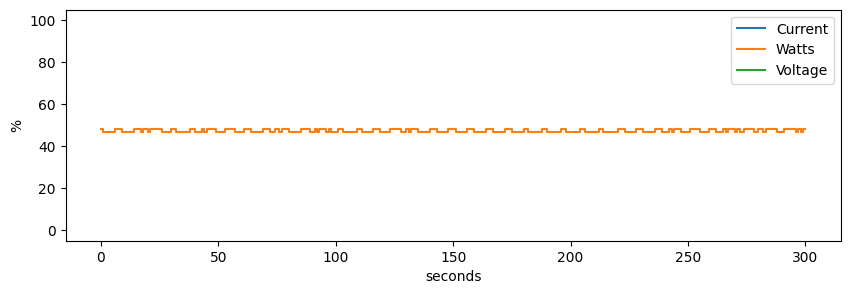

In [228]:
cpu_utilization = prepare_cpu_utilization(bm)
describe_measurement_dataframe(cpu_utilization)

grouped_mean = power_metrics.groupby(by=['seconds']).mean()
grouped_mean.drop(['measurement'], inplace=True, axis=1)
grouped_mean.plot(drawstyle='steps',figsize=(10,3),ylim=(-5,105),ylabel='%')

## Memory

[Measurement 1] Querying '
      100 * (1 - ((avg_over_time(node_memory_MemFree_bytes[10s]) + avg_over_time(node_memory_Cached_bytes[10s]) + avg_over_time(node_memory_Buffers_bytes[10s])) / avg_over_time(node_memory_MemTotal_bytes[10s])))
    ' from 1681634834 to 1681635134 with step 1s ...


### Total 

,"{instance=""192.168.178.79:9100"",job=""node""}"
count,301.000000
mean,1.063313
std,0.004534
min,1.055603
25%,1.059990
50%,1.063192
75%,1.065911
max,1.077417


### Per Measurement

                                                    measurement
{instance="192.168.178.79:9100",job="node"}  count  1              301.000000
                                             mean   1                1.063313
                                             std    1                0.004534
                                             min    1                1.055603
                                             25%    1                1.059990
                                             50%    1                1.063192
                                             75%    1                1.065911
                                             max    1                1.077417
dtype: float64

<Axes: xlabel='seconds', ylabel='%'>

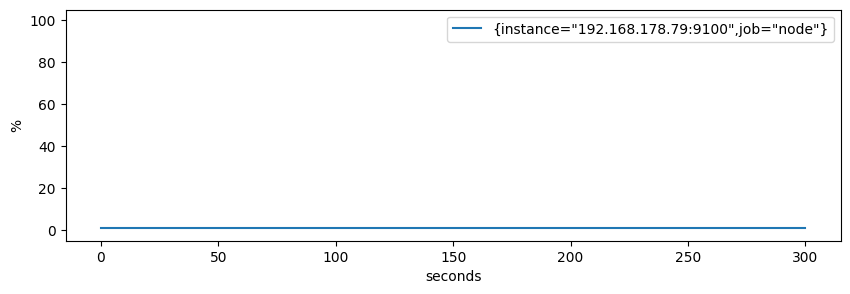

In [229]:
memory_usage = prepare_memory_utilization(bm)
describe_measurement_dataframe(memory_usage)

grouped_mean = memory_usage.groupby(by=['seconds']).mean()
grouped_mean.drop(['measurement'], inplace=True, axis=1)
grouped_mean.plot(drawstyle='steps',figsize=(10,3),ylim=(-5,105),ylabel='%')

## Network

In [230]:
# This is going to be the label filter we're going to use
net_filter_label = f"{{device=~\"{'|'.join(NET_DEVICES)}\"}}"

### Received KBytes

[Measurement 1] Querying 'sum by(device) (increase(node_network_receive_bytes_total{device=~"docker0|enp7s0|lo"}[5m])) / 1000' at 1681635134 ...


### Total 

,value
count,3.000000
mean,104.487625
std,180.977876
min,0.000000
25%,0.000000
50%,0.000000
75%,156.731438
max,313.462876


### Per Measurement

              measurement
value  count  1                3.000000
       mean   1              104.487625
       std    1              180.977876
       min    1                0.000000
       25%    1                0.000000
       50%    1                0.000000
       75%    1              156.731438
       max    1              313.462876
dtype: float64

<Axes: ylabel='Received KBytes'>

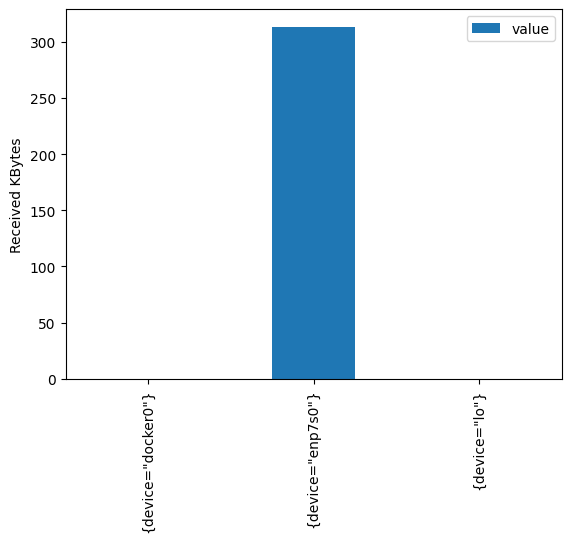

In [231]:
network_received_bytes = prepare_network_received_bytes(bm)
describe_measurement_dataframe(network_received_bytes)

grouped_mean = network_received_bytes.groupby(level=0).mean()
grouped_mean.drop(['measurement'], inplace=True, axis=1)
grouped_mean.plot.bar(ylabel='Received KBytes')

[Measurement 1] Querying 'avg by (device) (rate(node_network_receive_bytes_total{device=~"docker0|enp7s0|lo"}[10s]))' from 1681634834 to 1681635134 with step 1s ...


### Total 

,"{device=""docker0""}","{device=""enp7s0""}","{device=""lo""}"
count,301.0,301.000000,301.0
mean,0.0,1045.552602,0.0
std,0.0,43.988468,0.0
min,0.0,944.666667,0.0
25%,0.0,1012.444444,0.0
50%,0.0,1042.666667,0.0
75%,0.0,1073.333333,0.0
max,0.0,1157.333333,0.0


### Per Measurement

                           measurement
{device="docker0"}  count  1               301.000000
                    mean   1                 0.000000
                    std    1                 0.000000
                    min    1                 0.000000
                    25%    1                 0.000000
                    50%    1                 0.000000
                    75%    1                 0.000000
                    max    1                 0.000000
{device="enp7s0"}   count  1               301.000000
                    mean   1              1045.552602
                    std    1                43.988468
                    min    1               944.666667
                    25%    1              1012.444444
                    50%    1              1042.666667
                    75%    1              1073.333333
                    max    1              1157.333333
{device="lo"}       count  1               301.000000
                    mean   1               

<Axes: xlabel='seconds', ylabel='Bytes'>

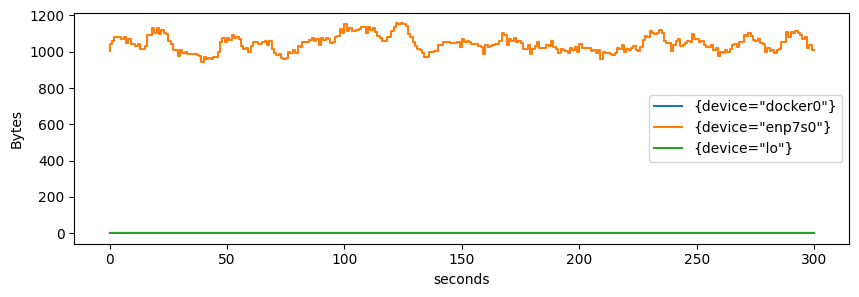

In [232]:
network_average_receive_rate = prepare_network_average_receive_rate(bm)
describe_measurement_dataframe(network_average_receive_rate)

grouped_mean = network_average_receive_rate.groupby(by=['seconds']).mean()
grouped_mean.drop(['measurement'], inplace=True, axis=1)
grouped_mean.plot(drawstyle='steps',figsize=(10,3),ylabel='Bytes')

### Sent KByte

[Measurement 1] Querying 'sum by(device) (increase(node_network_transmit_bytes_total{device=~"docker0|enp7s0|lo"}[5m])) / 1000' at 1681635134 ...


### Total 

,value
count,3.000000
mean,1981.348829
std,3431.796840
min,0.000000
25%,0.000000
50%,0.000000
75%,2972.023244
max,5944.046488


### Per Measurement

              measurement
value  count  1                 3.000000
       mean   1              1981.348829
       std    1              3431.796840
       min    1                 0.000000
       25%    1                 0.000000
       50%    1                 0.000000
       75%    1              2972.023244
       max    1              5944.046488
dtype: float64

<Axes: ylabel='Sent KBytes'>

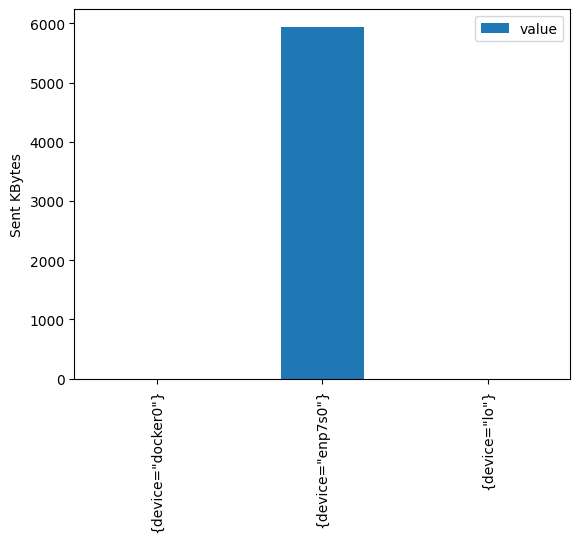

In [233]:
network_transmitted_bytes = prepare_network_transmitted_bytes(bm)
describe_measurement_dataframe(network_transmitted_bytes)

grouped_mean = network_transmitted_bytes.groupby(level=0).mean()
grouped_mean.drop(['measurement'], inplace=True, axis=1)
grouped_mean.plot.bar(ylabel='Sent KBytes')

[Measurement 1] Querying 'avg by (device) (rate(node_network_transmit_bytes_total{device=~"docker0|enp7s0|lo"}[10s]))' from 1681634834 to 1681635134 with step 1s ...


### Total 

,"{device=""docker0""}","{device=""enp7s0""}","{device=""lo""}"
count,301.0,301.000000,301.0
mean,0.0,19813.594684,0.0
std,0.0,8.070060,0.0
min,0.0,19785.111111,0.0
25%,0.0,19808.444444,0.0
50%,0.0,19814.222222,0.0
75%,0.0,19819.000000,0.0
max,0.0,19835.888889,0.0


### Per Measurement

                           measurement
{device="docker0"}  count  1                301.000000
                    mean   1                  0.000000
                    std    1                  0.000000
                    min    1                  0.000000
                    25%    1                  0.000000
                    50%    1                  0.000000
                    75%    1                  0.000000
                    max    1                  0.000000
{device="enp7s0"}   count  1                301.000000
                    mean   1              19813.594684
                    std    1                  8.070060
                    min    1              19785.111111
                    25%    1              19808.444444
                    50%    1              19814.222222
                    75%    1              19819.000000
                    max    1              19835.888889
{device="lo"}       count  1                301.000000
                    mean  

<Axes: xlabel='seconds', ylabel='Bytes'>

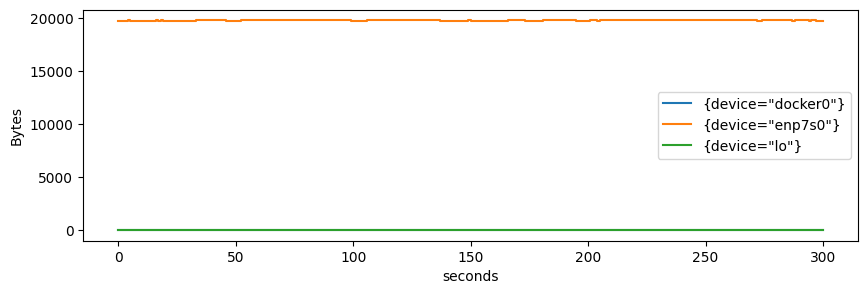

In [234]:
network_average_transmit_rate = prepare_network_average_transmit_rate(bm)
describe_measurement_dataframe(network_average_transmit_rate)

grouped_mean = network_average_transmit_rate.groupby(by=['seconds']).mean()
grouped_mean.drop(['measurement'], inplace=True, axis=1)
grouped_mean.plot(drawstyle='steps',figsize=(10,3),ylabel='Bytes')

# Disk

In [235]:
# This is going to be the label filter we're going to use
disk_filter_label = f"{{device=~\"{'|'.join(DISK_DEVICES)}\"}}"

In [236]:
total_disk_io_seconds = prepare_total_disk_io_seconds(bm)

grouped_result = total_disk_io_seconds.groupby(level=0).mean()
display(grouped_result)

[Measurement 1] Querying 'increase(node_disk_io_time_seconds_total{device=~"sda"}[10s])' at 1681635134 ...


,value,measurement
"{device=""sda"",instance=""192.168.178.79:9100"",job=""node""}",0.0,1.0


[Measurement 1] Querying 'avg by (device) (rate(node_disk_io_time_seconds_total{device=~"sda"}[10s]))' from 1681634834 to 1681635134 with step 1s ...


### Total 

,Current,Watts,Voltage
count,301.000000,301.000000,301.000000
mean,262.259136,47.438538,237.239203
std,0.786951,0.497034,0.427307
min,261.000000,47.000000,237.000000
25%,262.000000,47.000000,237.000000
50%,262.000000,47.000000,237.000000
75%,263.000000,48.000000,237.000000
max,265.000000,48.000000,238.000000


### Per Measurement

                measurement
Current  count  1              301.000000
         mean   1              262.259136
         std    1                0.786951
         min    1              261.000000
         25%    1              262.000000
         50%    1              262.000000
         75%    1              263.000000
         max    1              265.000000
Voltage  count  1              301.000000
         mean   1              237.239203
         std    1                0.427307
         min    1              237.000000
         25%    1              237.000000
         50%    1              237.000000
         75%    1              237.000000
         max    1              238.000000
Watts    count  1              301.000000
         mean   1               47.438538
         std    1                0.497034
         min    1               47.000000
         25%    1               47.000000
         50%    1               47.000000
         75%    1               48.000000
      

<Axes: xlabel='seconds', ylabel='I/O seconds'>

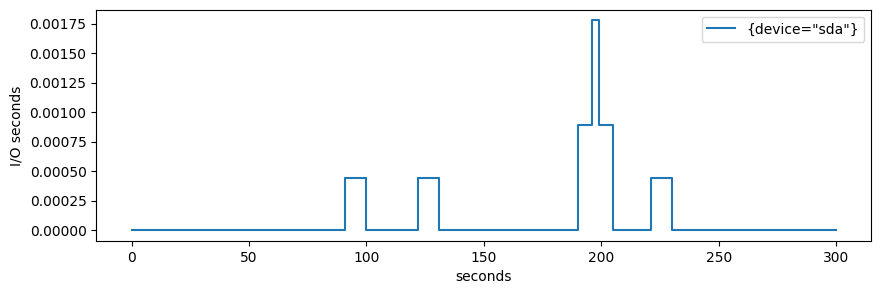

In [237]:
disk_io_rate = prepare_disk_io_rate(bm)
describe_measurement_dataframe(power_metrics)

grouped_mean = disk_io_rate.groupby(by=['seconds']).mean()
grouped_mean.drop(['measurement'], inplace=True, axis=1)
grouped_mean.plot(drawstyle='steps',figsize=(10,3),ylabel='I/O seconds')

# Interrupts

In [238]:
interrupts_filter = f"{{devices=\"\"}}"

[Measurement 1] Querying 'sum by (devices, type) (idelta(node_interrupts_total{devices=""}[5m]) > 0)' at 1681635134 ...


### Total 

,value
count,3.000000
mean,155.333333
std,208.696750
min,2.000000
25%,36.500000
50%,71.000000
75%,232.000000
max,393.000000


### Per Measurement

              measurement
value  count  1                3.000000
       mean   1              155.333333
       std    1              208.696750
       min    1                2.000000
       25%    1               36.500000
       50%    1               71.000000
       75%    1              232.000000
       max    1              393.000000
dtype: float64

,value
"{type=""CAL""}",71.0
"{type=""LOC""}",393.0
"{type=""RES""}",2.0


<Axes: ylabel='Interrupts'>

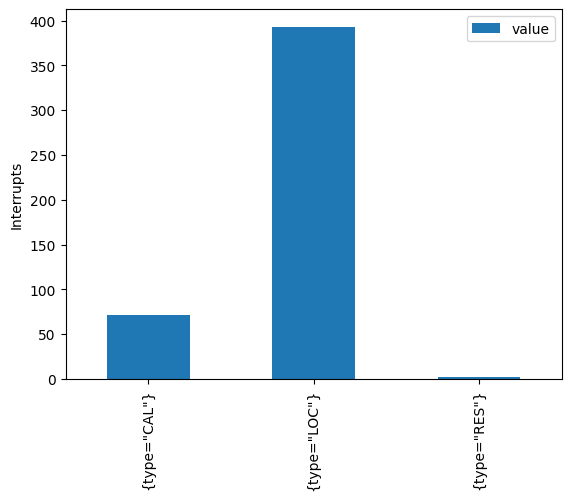

In [239]:
interrupts = prepare_interrupts(bm)
describe_measurement_dataframe(interrupts)

grouped_mean = interrupts.groupby(level=0).mean()
grouped_mean.drop(['measurement'], inplace=True, axis=1)
display(grouped_mean)
grouped_mean.plot.bar(ylabel='Interrupts')

# Software Experiment

In [240]:
# Those are the variants we have measured
VARIANTS=["no-cache", "caffeine-cache", "redis-cache", "caffeine-redis-cache"]